In [139]:
import numpy as np

In [140]:
from sklearn.datasets import make_blobs

In [178]:
X,y = make_blobs(n_samples=1000,n_features=2,centers=2,cluster_std=1.0)

In [142]:
import matplotlib.pyplot as plt
%matplotlib inline

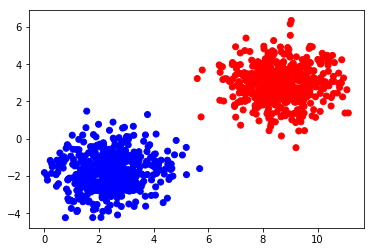

In [143]:
plt.scatter(X[:,0],X[:,1],c=y,cmap='bwr')

In [144]:
sig_value = np.arange(-20,21,1)

In [145]:
sig = 1/(1+np.exp(-sig_value))

In [146]:
sig_diff = np.exp(-sig_value)/((1+np.exp(-sig_value))**2)

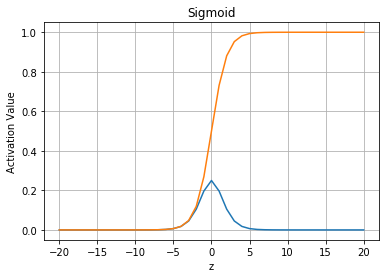

In [147]:
plt.plot(sig_value,sig_diff)
plt.plot(sig_value,sig)
plt.grid(True)
plt.xlabel('z')
plt.ylabel('Activation Value')
plt.title('Sigmoid')

In [148]:
relu_value = sig_value
relu = [0 if i<0 else i for  i in relu_value]
relu_diff = [1 if i>0 else 0 for i in relu_value]

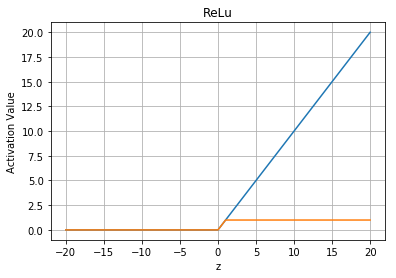

In [149]:
plt.plot(relu_value,relu)
plt.plot(relu_value,relu_diff)
plt.grid(True)
plt.xlabel('z')
plt.ylabel('Activation Value')
plt.title('ReLu')

In [150]:
architecture = [
    {"input":2,"output":6,"activation":"relu"},
    {"input":6,"output":6,"activation":"relu"},
    {"input":6,"output":6,"activation":"relu"},
    {"input":6,"output":6,"activation":"relu"},
    {"input":6,"output":6,"activation":"relu"},
    {"input":6,"output":1,"activation":"sigmoid"},
]

In [151]:
def init_layers(nn_architecture,seed=99):
    np.random.seed(seed)
    num_of_layers = len(nn_architecture)
    param_values = {}
    
    for idx,layer in enumerate(nn_architecture):
        layer_idx = idx+1
        layer_input_dim = layer["input"]
        layer_output_dim = layer["output"]
        
        param_values['W' + str(layer_idx)] = np.random.randn(layer_output_dim,layer_input_dim)*0.1
        param_values['b' + str(layer_idx)] = np.random.randn(layer_output_dim,1)*0.1
    return param_values

In [152]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA,Z):
    sig = sigmoid(Z)
    return dA*sig*(1-sig)

def relu_backward(dA,Z):
    dZ = np.array(dA,copy=True)
    dZ[Z<=0] = 0
    return dZ

In [153]:
def single_forward_propagation(A_prev,curr_w,curr_b,activation):
    
    Z_curr = np.dot(curr_w,A_prev) + curr_b
    
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception("Activation function not supported.")
    
    return activation_func(Z_curr), Z_curr

In [206]:
def full_forward_propagation(X,params_values,nn_architecture):
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activation_function_current = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        
        A_curr, Z_curr = single_forward_propagation(A_prev, W_curr, b_curr, activation_function_current)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
    
    return A_curr, memory

In [207]:
def get_cost_value(Y_hat,Y):
    m = Y_hat.shape[1]
    cost = -1/m * (np.dot(Y,np.log(Y_hat).T) + np.dot((1-Y),np.log(1-Y_hat).T))
    return np.squeeze(cost)

In [208]:
def get_accuracy_value(Y_hat,Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat==Y).all(axis=0).mean()

In [209]:
def single_backward_propagation(dA_curr,W_curr,b_curr,Z_curr,A_prev,activation="relu"):
    m = A_prev.shape[1]
    
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception("Activation function not supported.")
    
    dZ_curr = backward_activation_func(dA_curr,Z_curr)
    dW_curr = np.dot(dZ_curr,np.transpose(A_prev)) / m
    db_curr = 1/m * np.sum(dZ_curr,axis=1,keepdims=True)
    dA_prev = np.dot(W_curr.T,dZ_curr)
    
    return dA_prev, dW_curr, db_curr

In [210]:
def full_backward_propagation(Y,Y_hat,memory,params_values,nn_architecture):
    grads_values = {}
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
    
    dA_prev = - (np.divide(Y,Y_hat) - np.divide(1-Y,1-Y_hat))
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]

        dA_prev, dW_curr, db_curr = single_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
        
    return grads_values

In [218]:
def update(params_values,grads_values,nn_architecture,learning_rate):
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx+1
        params_values["W" + str(layer_idx)] -= learning_rate*grads_values["W" + str(layer_idx)]
        params_values["b" + str(layer_idx)] -= learning_rate*grads_values["b" + str(layer_idx)]
    return params_values

In [219]:
# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [220]:
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [221]:
# def train(X,Y,nn_architecture,epochs,learning_rate):
#     params_values = init_layers(nn_architecture,2)
#     cost_history = []
#     accuracy_history = []
#     for i in range(epochs):
#         Y_hat, cache = forward_propagation(X, params_values,nn_architecture)
#         cost = get_cost_value(Y_hat, Y)
#         cost_history.append(cost)
        
#         grads_values = full_backward_propagation(Y_hat, Y, cache, params_values,nn_architecture)
#         params_values = update(params_values,nn_architecture,learning_rate)
        
#     return params_values, cost_history

In [222]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values

In [223]:
epochs = 10000
learning_rate = 0.01

In [224]:
params_values, cost_history = train(np.transpose(X),np.transpose(np.reshape(y,(y.shape[0],1))),architecture,epochs,learning_rate)

C:\Users\Lolly\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Lolly\Anaconda3\envs\carnd-term1\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


KeyError: 'W1'